# Определение возраста покупателей


Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
  
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
  
- контролировать добросовестность кассиров при продаже алкоголя.  
  
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.  

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
# Размер выборки
print(f"Размер выборки: {len(labels)}")

Размер выборки: 7591


Построим графики распредления возрастов в сете

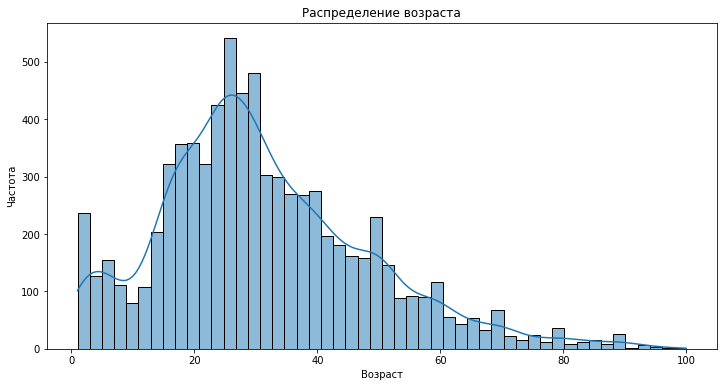

In [ ]:
# График распределения возраста
plt.figure(figsize=(12, 6))
sns.histplot(labels['real_age'], bins=50, kde=True)
plt.title("Распределение возраста")
plt.xlabel("Возраст")
plt.ylabel("Частота")
plt.show()

Пропусков нет, распределение скошено направо, ассиметрично-положительно. Среднее значение больше медианы, наблюдается длинный хвост, максимальный возраст - 100 лет: данная категория людей относится к долгожителям и не является часто встречающейся - это может сказаться на точности определения данной возрастной группы



Загрузим фотоизображения. Использовать будем класс ImageDataGenerator, который будем использовать при обучении модели



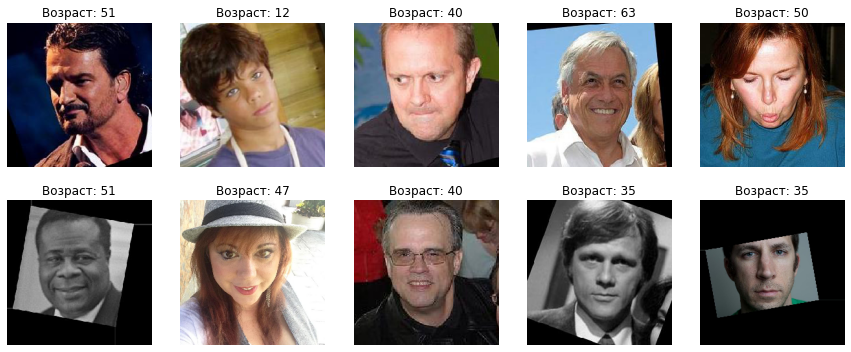

In [ ]:
# Вывод 10-15 изображений
images, ages = next(train_gen_flow)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(f"Возраст: {ages[i]}")
    ax.axis("off")
plt.show()

Как мы видим, количество людей старше 90 лет встречается в сете достаточно редко. Высокая точность должна наблюдаться на образцах возрастом 20-41 год, на других возрастных группах - возможно увеличение ошибки. Метрику возьмем MAE - она наиболее робастная по отношению к выбросам и лучше интерпритируется. При построении модели обязательно включим в последний слой функцию активации, чтобы не получить отрицательный возраст



## Обучение модели

Код в этом разделе и вычисления производились на сервере с графической картой (GPU) Yandex Compute Cloud



In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

# загрузка обучающей выборки

def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

# загрузка валидационной выборки

def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')
    datagen = ImageDataGenerator(rescale=1. / 255)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

    return test_datagen_flow

# Создание модели на архитектуре ResNet50

def create_model(input_shape=(224, 224, 3)):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer=Adam(lr=0.0001), metrics=['mae'])

    return model



def train_model(model, train_data, test_data, epochs=8, batch_size=None,
               steps_per_epoch=None, validation_steps=None):

    train_datagen_flow = train_data
    test_datagen_flow = test_data

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=(test_data), epochs=epochs,
              steps_per_epoch=steps_per_epoch, batch_size=batch_size,
              validation_steps=validation_steps, 
              verbose=2, shuffle=True)
    return model

In [ ]:
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
  
Train for 356 steps, validate for 475 steps
Epoch 1/8
356/356 - 85s - loss: 214.1144 - mae: 10.6022 - val_loss: 906.1923 - val_mae: 25.1945
Epoch 2/8
356/356 - 77s - loss: 69.1863 - mae: 6.3789 - val_loss: 224.5743 - val_mae: 11.0451
Epoch 3/8
356/356 - 78s - loss: 38.3333 - mae: 4.8190 - val_loss: 83.4200 - val_mae: 7.2569
Epoch 4/8
356/356 - 77s - loss: 26.1508 - mae: 3.9479 - val_loss: 32.0436 - val_mae: 3.9245
Epoch 5/8
356/356 - 77s - loss: 17.1180 - mae: 3.1677 - val_loss: 36.6215 - val_mae: 4.4733
Epoch 6/8
356/356 - 73s - loss: 13.2297 - mae: 2.7935 - val_loss: 36.3859 - val_mae: 4.4554
Epoch 7/8
356/356 - 70s - loss: 12.2127 - mae: 2.6547 - val_loss: 27.8562 - val_mae: 3.6965
Epoch 8/8
356/356 - 72s - loss: 10.8959 - mae: 2.5082 - val_loss: 35.4658 - val_mae: 4.2594


475/475 - 39s - loss: 35.4658 - mae: 4.2594
Test MAE: 4.2594

## Анализ обученной модели

Построили модель, которая по фотографии определит приблизительный возраст человека с ошибкой 4.25 года. Стоить отметить, что даже при небольшом количестве эпох наблюдается переобучение - мы видим значительное улучшение качества на обучающей выборке, при этом на валидационной выборке качество растет значительно медленнее. Данный факт связан со склонностью многослойных архитектур сетей к переобучению и не можем сигнализировать о плохом качестве модели, в данном случае - при необходимости, можно провести дополнительные тесты и понаблюдать, как модель обобщается. Можно уменьшить количество эпох до 4.

Было поставлено две основные цели данного проекта:

анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

контролировать добросовестность кассиров при продаже алкоголя.

По первому пункту ошибка допустима, по второму необходимо провести дополнительную проверку данных возрастных групп до 18 лет.